In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style = 'white', font_scale=1.5)

from umap import UMAP

/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distanc

In [10]:
gide = pd.read_csv('./Gide/raw/unstranded_tpm.csv',index_col = 0)
gide['cohort'] = 'Gide'

In [11]:
tcga_skcm = pd.read_csv('/n/data1/hms/dbmi/zitnik/lab/users/was966/TCGA/GDC_v37/TCGA-SKCM/rnaSeq_tpm_matrix.csv', index_col=0)
tcga_skcm = tcga_skcm.T
tcga_skcm['cohort'] = 'TCGA-SKCM'

In [13]:
skcm = pd.concat([gide, tcga_skcm])

In [16]:
com_genes = gide.columns[:-1]

In [17]:
def _sel_genes(x):
    var = x[com_genes].var(axis=0) 
    sel_genes = var[var > 1].index
    return sel_genes

sgenes = skcm.groupby('cohort').apply(lambda x:_sel_genes(x).tolist()).tolist()
sgenes = list(set.intersection(*map(set, sgenes)))

In [19]:
print(len(sgenes))

dfmp = skcm[sgenes]
dfmp = np.log2(dfmp+1)
#dfmp = dfmp.join(dfm.cohort)

15659


In [28]:
mp = UMAP(spread=2.5, random_state=123)
skcm_genes_2d = mp.fit_transform(dfmp)

In [29]:
dfp_skcm = pd.DataFrame(skcm_genes_2d, columns=['x', 'y'],index=skcm.index)
dfp_skcm = dfp_skcm.join(skcm[skcm.columns[-1:]])

Text(0, 0.5, 'UMAP2')

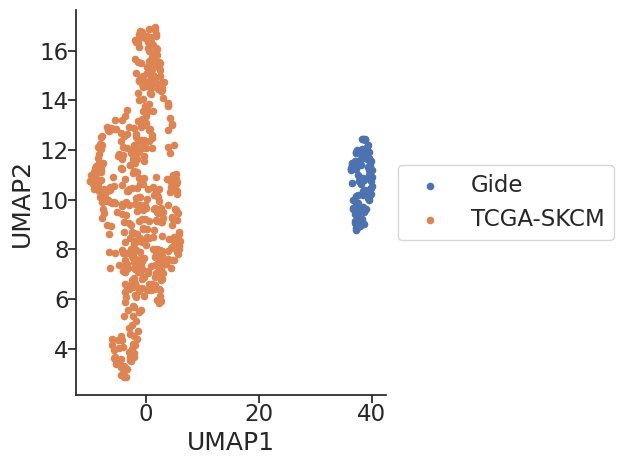

In [30]:
fig, ax = plt.subplots(figsize=(4,5))
cohorts = [ 'Gide', 'TCGA-SKCM', ]
for bt in cohorts:
    dfp1 = dfp_skcm[dfp_skcm.cohort == bt]
    if bt == 'TCGA':
        bt = 'TCGA-SKCM'
    ax.scatter(dfp1.x, dfp1.y, label = bt, s = 20)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

In [37]:
df_save = skcm[['cohort']].join(skcm[sgenes])
df_save.to_csv('batch_effect_test.csv')

In [43]:
def plot_batch_effect(df_save, log2=False):
    sgenes = df_save.columns[1:]
    dfmp = df_save[sgenes]
    if log2:
        dfmp = np.log2(dfmp+1)
    
    mp = UMAP(spread=2.5, random_state=123)
    genes_2d = mp.fit_transform(dfmp)
    
    dfp = pd.DataFrame(genes_2d, columns=['x', 'y'],index=df_save.index)
    dfp = dfp.join(df_save)
    
    
    fig, ax = plt.subplots(figsize=(4,5))
    cohorts = dfp.cohort.unique()
    for bt in cohorts:
        dfp1 = dfp[dfp.cohort == bt]
        ax.scatter(dfp1.x, dfp1.y, label = bt, s = 20)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
    sns.despine(top=True, right=True, left=False, bottom=False)
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')

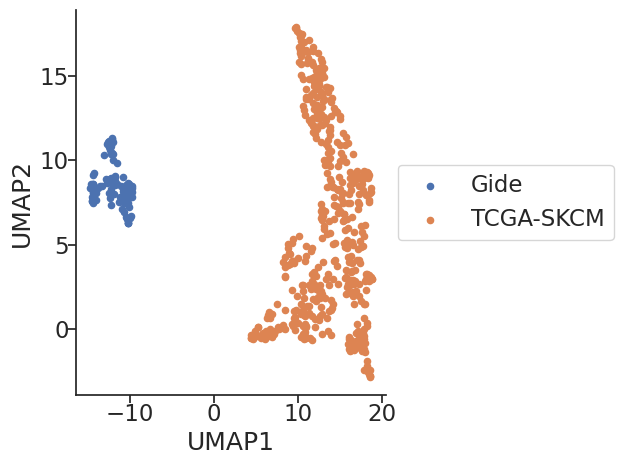

In [44]:
plot_batch_effect(df_save)